In [1]:
# Imports PyTorch and alias some parts of it
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# matplotlib for visualisation
import matplotlib.pyplot as plt

# tqdm for loading bars
import tqdm

In [2]:
# Make the size of the figures larger
plt.rcParams['figure.figsize'] = [20, 20]

In [3]:
# Some script parameters
USE_CUDA = True
BATCH_SIZE = 64
NB_EPOCHS = 5

In [4]:
# Load CUDA device if available
device = torch.device('cuda' if USE_CUDA and torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
# Inherit from the MNIST dataset class and add my own segmentation code
class SegmentationMNIST(torchvision.datasets.MNIST):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.transforms = torchvision.transforms.Compose([
      torchvision.transforms.Resize(32),
      torchvision.transforms.ToTensor()
    ])

  def __getitem__(self, idx):
    THRESHOLD = 0.5
    x, label = super().__getitem__(idx)

    x = self.transforms(x)
    mask = (x > THRESHOLD)
    y = torch.zeros(10, 32, 32)
    y[label:label+1] += mask
    return x, y, label

In [6]:
# Loads dataset and dataloaders
train_dataset, test_dataset = SegmentationMNIST("data", train=True, download=True), \
                              SegmentationMNIST("data", train=False, download=True)

train_dataloader, test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True), \
                                    torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
# U-Net downsampling layer module
# 2x Conv (3x3) -> ReLU -> MaxPool (2x2)
class UNetDownLayer(nn.Module):
  def __init__(self, in_ch, out_ch, dropout=0.0):
    super().__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, padding=1),
                               nn.BatchNorm2d(out_ch),
                               nn.Dropout(dropout))
    self.conv2 = nn.Sequential(nn.Conv2d(out_ch, out_ch, 3, padding=1),
                               nn.BatchNorm2d(out_ch),
                               nn.Dropout(dropout))

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)

    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)

    return x

# U-Net upsampling layer module
# UpConv (2x2 -> Concatenate -> 2x Conv (3x3) -> ReLU
class UNetUpLayer(nn.Module):
  def __init__(self, in_ch, out_ch, dropout=0.0):
    super().__init__()
    self.up_conv = nn.Sequential(nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
                               nn.BatchNorm2d(out_ch),
                               nn.Dropout(dropout))
    self.conv1 = nn.Sequential(nn.Conv2d(out_ch*2, out_ch, 3, padding=1),
                               nn.BatchNorm2d(out_ch),
                               nn.Dropout(dropout))
    self.conv2 = nn.Sequential(nn.Conv2d(out_ch, out_ch, 3, padding=1),
                               nn.BatchNorm2d(out_ch),
                               nn.Dropout(dropout))
    
  def forward(self, x, z):
    x = self.up_conv(x)
    xz = torch.cat([x, z], dim=1)
  
    xz = self.conv1(xz)
    xz = self.conv2(xz)

    xz = F.relu(xz)
    return xz

# Main U-Net model module
class UNet(nn.Module):
  def __init__(self, in_ch, init_channels, nb_classes, nb_layers, dropout=0.0):
    super().__init__()
    assert(nb_layers > 1) # Number of layers must be more than 1

    # Create contracting path of downsampling layers
    self.contract = nn.ModuleList()
    prev_size = in_ch
    next_size = init_channels

    for l in range(nb_layers):
      self.contract.append(UNetDownLayer(prev_size, next_size, dropout=dropout))
      prev_size, next_size = next_size, next_size*2

    # Create expanding path of upsampling layers
    self.expand = nn.ModuleList()
    next_size = prev_size // 2
    for l in range(nb_layers - 1):
      self.expand.append(UNetUpLayer(prev_size, next_size, dropout=dropout))
      prev_size, next_size = next_size, next_size // 2

    # Creates output head, resizing to correct dimensions. Then (1x1) conv to nb_classes channels
    self.out = nn.Sequential(nn.ConvTranspose2d(prev_size, prev_size, 2, stride=2),
                             nn.BatchNorm2d(prev_size),
                             nn.Dropout(dropout),
                             nn.Conv2d(prev_size, nb_classes, 1))

  def forward(self, x):
    # Store intermediate values in downsampling path
    tiles = []

    for l in self.contract:
      x = l(x)
      tiles.append(x.clone())

    tiles = tiles[::-1]
    for i, l in enumerate(self.expand):
      x = l(x, tiles[i+1])

    x = self.out(x)
    x = torch.sigmoid(x) # Sigmoid as possible for the same pixel to belong to multiple classes
    return x

model = UNet(1, 64, 10, 5).to(device)

In [8]:
optim = torch.optim.Adam(model.parameters())
crit = nn.MSELoss()

# Main training loop
for ei in range(NB_EPOCHS):
  # Training Mode
  model.train()
  training_loss = 0.0
  evaluation_loss = 0.0
  for bx, by, _ in tqdm.tqdm(train_dataloader):
    optim.zero_grad()
    bx, by = bx.to(device), by.to(device)
    pred = model(bx)

    loss = crit(by, pred)
    training_loss += loss.item()

    loss.backward()
    optim.step()

  # Evaluation Mode
  with torch.no_grad():
    model.eval()
    for bx, by, _ in test_dataloader:
      optim.zero_grad()
      bx, by = bx.to(device), by.to(device)
      pred = model(bx)

      loss = crit(by, pred)
      evaluation_loss += loss.item()

    print(f"\nEpoch {ei+1} end.")
    print(f"Training Loss: {training_loss / len(train_dataloader)}")
    print(f"Validation Loss: {evaluation_loss / len(test_dataloader)}")

  0%|          | 2/938 [00:00<00:59, 15.80it/s]


Epoch 1 end.
Training Loss: 0.03532183061895976
Validation Loss: 0.010740425508872718


  0%|          | 2/938 [00:00<00:59, 15.85it/s]


Epoch 2 end.
Training Loss: 0.004102323964515677
Validation Loss: 0.0012810243557616595


  0%|          | 2/938 [00:00<00:59, 15.74it/s]


Epoch 3 end.
Training Loss: 0.001119142012317667
Validation Loss: 0.0009104743452333389


  0%|          | 2/938 [00:00<00:59, 15.64it/s]


Epoch 4 end.
Training Loss: 0.0008315663574499759
Validation Loss: 0.0006864715310460205


100%|██████████| 938/938 [01:15<00:00, 12.35it/s]



Epoch 5 end.
Training Loss: 0.0006539323699638508
Validation Loss: 0.0006098145543772633


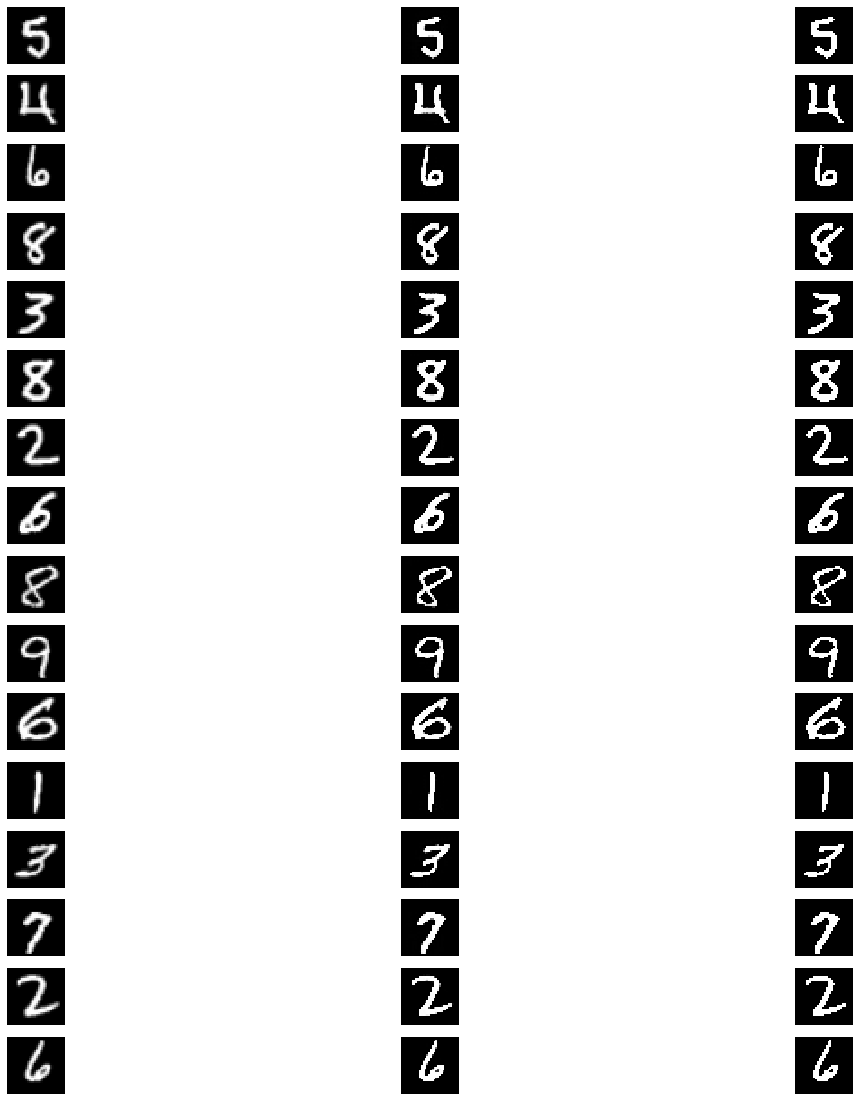

In [9]:
# Visualise input image, true label mask and predicted label mask
model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

fix, axs = plt.subplots(16, 3)

for i, (x, y, l) in enumerate(test_loader):
  if i == 16:
    break

  x = x.to(device)
  pred = model(x)

  x = x.reshape(32, 32).detach().cpu().numpy()
  y = y[0, l, :, :].reshape(32, 32).detach().cpu().numpy()
  pred = pred[0, l, :, :].reshape(32, 32).detach().cpu().numpy()

  axs[i, 0].imshow(x, interpolation='none', cmap='gray')
  axs[i, 1].imshow(pred, interpolation='none', cmap='gray')
  axs[i, 2].imshow(y, interpolation='none', cmap='gray')
[[x.axis(False) for x in y] for y in axs]
plt.show()